In [31]:
import pandas as pd
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import warnings
import itertools
import numpy as np
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
import matplotlib
import sys
%matplotlib inline

sessions = pd.read_json("../data/raw/second/sessions.jsonl", lines=True)
buy_sessions = sessions[sessions['event_type'] == 'BUY_PRODUCT'].copy()
buy_sessions['purchase_id'] = buy_sessions['purchase_id'].astype(int)
buy_sessions['date']=buy_sessions['timestamp'].dt.date
buy_sessions.drop(columns=['user_id', 'event_type', 'offered_discount','session_id','timestamp'], inplace=True)
products_per_day = buy_sessions.groupby(by=['date','product_id']).count().unstack(fill_value=0).stack().rename(columns={'purchase_id': 'amount'}).reset_index()
print(products_per_day)

              date  product_id  amount
0       2019-08-01        1002       1
1       2019-08-01        1003       0
2       2019-08-01        1004       0
3       2019-08-01        1005       0
4       2019-08-01        1006       1
...            ...         ...     ...
171976  2021-12-20        1310       0
171977  2021-12-20        1311       0
171978  2021-12-20        1312       0
171979  2021-12-20        1313       0
171980  2021-12-20        1314       0

[171981 rows x 3 columns]


In [32]:
products_per_day['date']=pd.to_datetime(products_per_day['date'])
products_per_day['product_id'] = products_per_day['product_id'].astype(str)
df=products_per_day[products_per_day['product_id']=='1007']
df=df.groupby(pd.Grouper(key='date', freq="D")).sum() # tutaj moze byc też freq="W", musimy pomyśleć co jest lepsze
print(df.tail(30))

            amount
date              
2021-11-21       0
2021-11-22       0
2021-11-23       0
2021-11-24       0
2021-11-25       0
2021-11-26       0
2021-11-27       0
2021-11-28       0
2021-11-29       0
2021-11-30       0
2021-12-01       0
2021-12-02       0
2021-12-03       0
2021-12-04       0
2021-12-05       0
2021-12-06       0
2021-12-07       0
2021-12-08       0
2021-12-09       0
2021-12-10       0
2021-12-11       0
2021-12-12       0
2021-12-13       0
2021-12-14       0
2021-12-15       0
2021-12-16       0
2021-12-17       1
2021-12-18       0
2021-12-19       0
2021-12-20       0


In [33]:
print(df)

            amount
date              
2019-08-01       2
2019-08-02       3
2019-08-03       7
2019-08-04       6
2019-08-05       1
...            ...
2021-12-16       0
2021-12-17       1
2021-12-18       0
2021-12-19       0
2021-12-20       0

[873 rows x 1 columns]


<AxesSubplot:xlabel='date'>

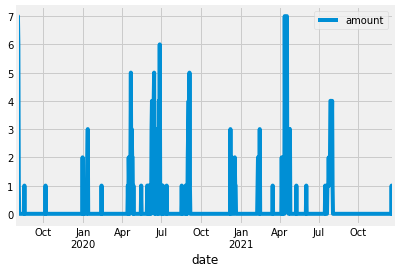

In [34]:
df.plot(y='amount',use_index=True)

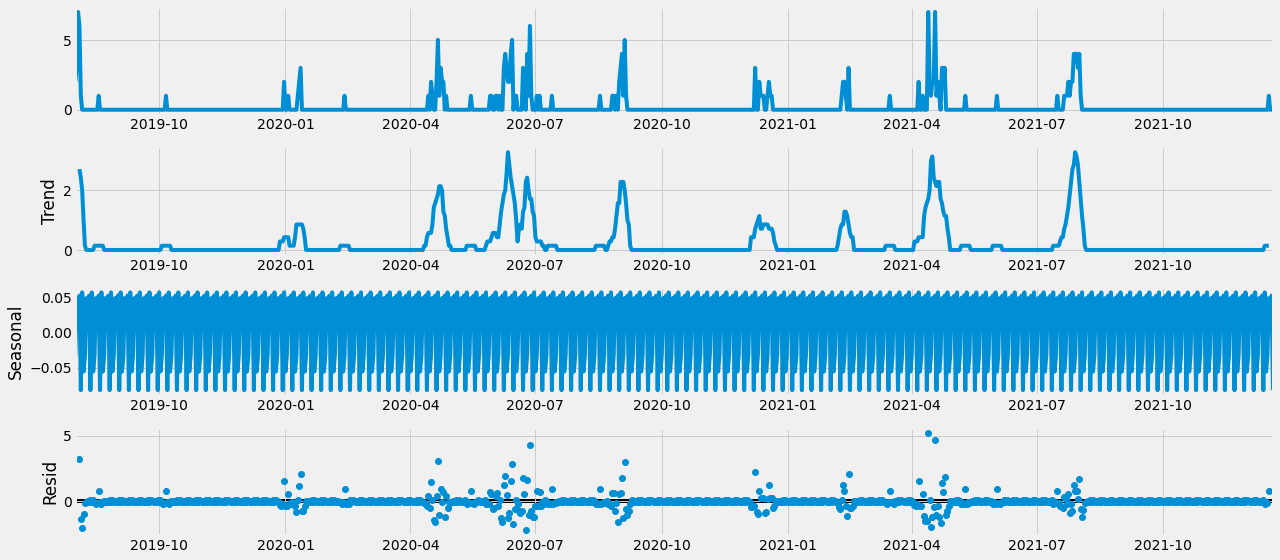

In [45]:

rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

In [38]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [39]:
best_aic=sys.maxsize
best_param=(1,1,1)
best_param_seasonal=(1,1,1,12)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            message='ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic)
            print(message)
            if results.aic<best_aic:
                best_param=param
                best_param_seasonal=param_seasonal
                best_aic=results.aic
        except Exception as e: 
            print(str(e))
print("*****************")
print("Best parameters:")
print('ARIMA{}x{}12 - AIC:{}'.format(best_param,best_param_seasonal,best_aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2250.7423517653087
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2078.7087564977464
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2614.241503511492
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2112.4370536215
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2081.9632078987283
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2080.2730642007373
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2360.187500536201
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2058.256302272286
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2037.2637553242098
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1913.0009077457416
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2450.9506838259613
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1943.3658373197254
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1915.9268785612444
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1914.6942779764659
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2203.1420871817813
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1906.2782863528823
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2106.008764677166
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2021.5923756426353

In [41]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=best_param,
                                seasonal_order=best_param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8819      0.013     67.799      0.000       0.856       0.907
ma.L1         -0.5277      0.025    -20.920      0.000      -0.577      -0.478
ma.S.L12       0.0519      0.018      2.827      0.005       0.016       0.088
sigma2         0.4236      0.006     76.079      0.000       0.413       0.435


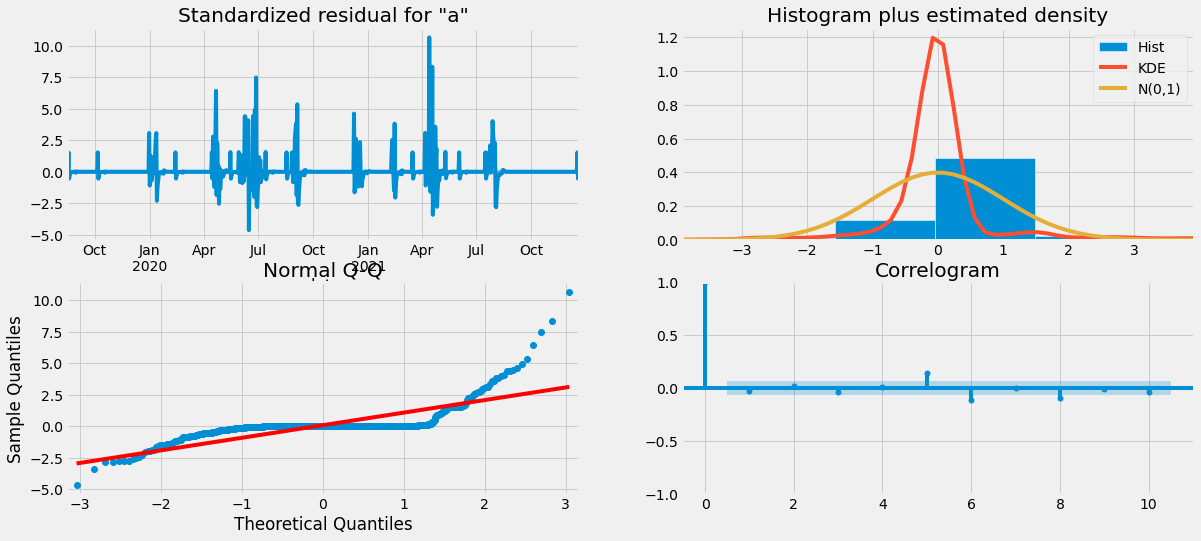

In [42]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

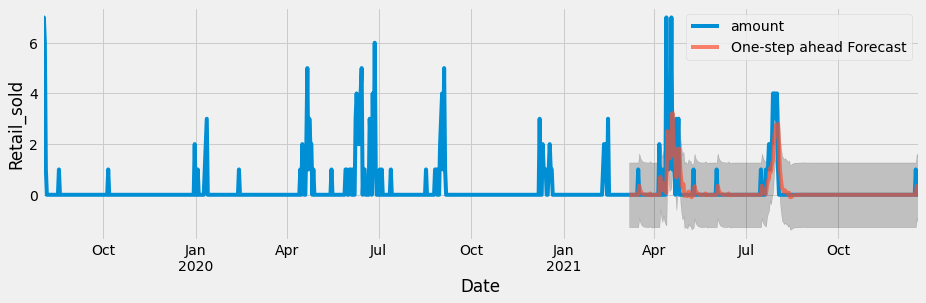

In [43]:
pred = results.get_prediction(start=pd.to_datetime('2021-03-07'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

In [50]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['amount'], trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=746.833, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=747.079, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=743.404, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=744.192, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=761.210, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=745.213, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=745.311, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=751.143, Time=0.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 0.565 seconds


In [84]:
cutoff_point=int(len(df)*0.2)
train=df[:-cutoff_point]
test=df[-cutoff_point:]
print(len(train))
print(len(test))
model=ARIMA(train['amount'],order=(5,0,0),freq='W')
model=model.fit()
model.summary()

101
25


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 amount   No. Observations:                  101
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -294.372
Date:                Wed, 12 Jan 2022   AIC                            602.743
Time:                        00:09:40   BIC                            621.049
Sample:                    08-04-2019   HQIC                           610.154
                         - 07-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8385      1.375      1.337      0.181      -0.857       4.534
ar.L1          0.1938      0.117      1.661      0.097      -0.035       0.422
ar.L2          0.0992      0.092      1.078      0.281      -0.081       0.280
ar.L3         -0.1022      0.507     -0.202      0.840      -1.097       0.892
ar.L4         -0.0635      0.322     -0.197      0.844      -0.695       0.568
ar.L5         -0.0608      0.416     -0.146      0.884      -0.877       0.755
sigma2        19.8818      3.165      6.281      0.000      13.678      26.086
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               444.15
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.68   Skew:                             2.88
Prob(H) (two-sided):                  0.14   Kurtosis:                        11.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:xlabel='date'>

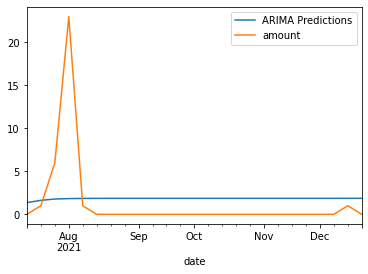

In [82]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
test['amount'].plot(legend=True)

<AxesSubplot:xlabel='date'>

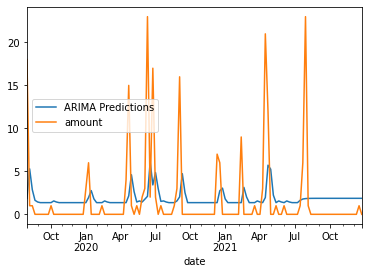

In [83]:
end=len(train)+len(test)-1
pred=model.predict(start=0,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
df['amount'].plot(legend=True)